
# Eksploratorna analiza podataka za projekt 'Detekcija raka na temelju histoloških preparata'


**Bjanka Bašić, Ivan Knezić i Jelena Lončar**

travanj 2019.

## Opis podataka

Odabran je dataset s web stranice <a href='https://www.kaggle.com/c/histopathologic-cancer-detection/data'>Kaggle</a>. Radi se o skupu podataka koji je jednak PatchCamelyon (PCam) benchmark skupu podataka, dostupnom na sljedećem
linku: https://github.com/basveeling/pcam, osim što su uklonjeni duplikati, inače prisutni u PCam skupu podataka zbog slučajnog uzorkovanja. U odabranom se datasetu nalazi 220025 primjera za treniranje i 57458 primjera za testiranje.

Podaci koje koristimo sastoje se od velikog broja malih fotografija koje treba klasificirati,
kao i od datoteke koja sadrži stvarne vrijednosti ciljne varijable za pojedine primjere iz train skupa.
Fotografije u skupu podataka dimenzija su 96 x 96px, a ono što rješavanje ovog problema čini
osobito izazovnim jest to što metastaze mogu biti reda veličine jedne stanice usred velikog područja
tkiva. Određen se primjer smatra pozitivnim primjerom ako centralno područje fotografije
dimenzija 32 x 32px sadrži barem jedan piksel tumorskog tkiva. Tumorsko tkivo u okolnom
području fotografije ne utječe na vrijednost ciljne varijable.

In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('../train/train_labels.csv')
train_path = '../train/'
test_path = '../test/'

In [3]:
train_labels = pd.read_csv(train_path+'train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Omjer negativnih i pozitivnih primjera

In [4]:
cnt_train = data['id'].count()
cnt_train

220025

In [5]:
neg_train, pos_train = data['label'].value_counts()
print(neg_train, pos_train)

130908 89117


In [6]:
def ra(a, b):
    a = float(a)
    b = float(b)
    if b == 0:
        return a
    return ra(b, a % b)

def get_ratio(a, b):
    r = ra(a, b)
    return '%.2f' % float((a/r) / (b/r))

def ratio(a, b):
    return '%.f/%.f' % (float(a)/(a+b)*100, float(b)/(a+b)*100)

In [7]:
get_ratio(neg_train, pos_train), ratio(neg_train, pos_train)

('1.47', '59/41')

Od ukupno 220025 primjera u skupu podataka za učenje, za njih 130908 vrijednost je ciljne varijable 0 (to su negativni primjeri, odnosno oni koji ne predstavljaju tkivo bez metastaza), a za njih 89117 vrijednost je ciljne varijable 1 (to su pozitivni primjeri, odnosni koji koji predstavljaju tkivo s prisutnim metastazama). Primijetimo da je negativnih primjera skoro 1.5 puta više od pozitivnih tj. preciznije **omjer negativni/pozitivni jednak je 59/41**. Dobro je zamijetiti kako bi trivijalan klasifikator, koji sve primjere klasificira kao negativne, postigao točnost od 60%.

Prikažimo distribuciju podataka pomoću grafa:

Text(0, 0.5, 'Broj primjera')

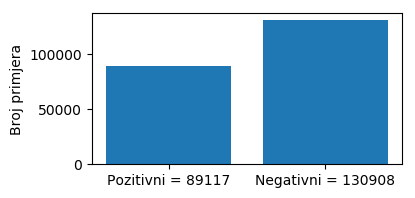

In [8]:
fig = plt.figure(figsize=(4, 2), dpi=100)
plt.bar([1, 0], [neg_train, pos_train]) # Crtamo bar graf frekvencija pojedinih vrijednosti ciljne varijable
plt.xticks([1, 0],["Negativni = {}".format(neg_train), "Pozitivni = {}".format(pos_train)])
plt.ylabel("Broj primjera")

## Izgled primjera u skupu podataka

In [9]:
# Potrebno je obrnuti kanale da bi se dobio izvorni izgled slike
def readImage(path):
    bgr_img = cv2.imread(path)
    b, g, r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [10]:
readImage('../train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif').shape

(96, 96, 3)

Fotografije iz skupa podataka za učenje reprezentirane su tenzorima dimenzija 96 x 96 x 3, pri čemu je zadnja vrijednost jednaka 3 zbog 3 kanala: red, green i blue.

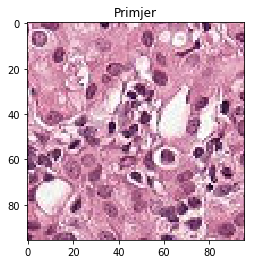

In [11]:
plt.title('Primjer')
plt.imshow(readImage('../train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif'))

Prikazat ćemo 4 primjera fotografija iz skupa podataka za učenje bez tumorskog tkiva i 4 s prisutnim tumorskim tkivom (isprekidanim je pravokutnikom označen dio koji se uzimao u obzir pri označavanju preparata).

Text(0.5, 0.98, 'Histološki preparati tkiva limfnih čvorova ')

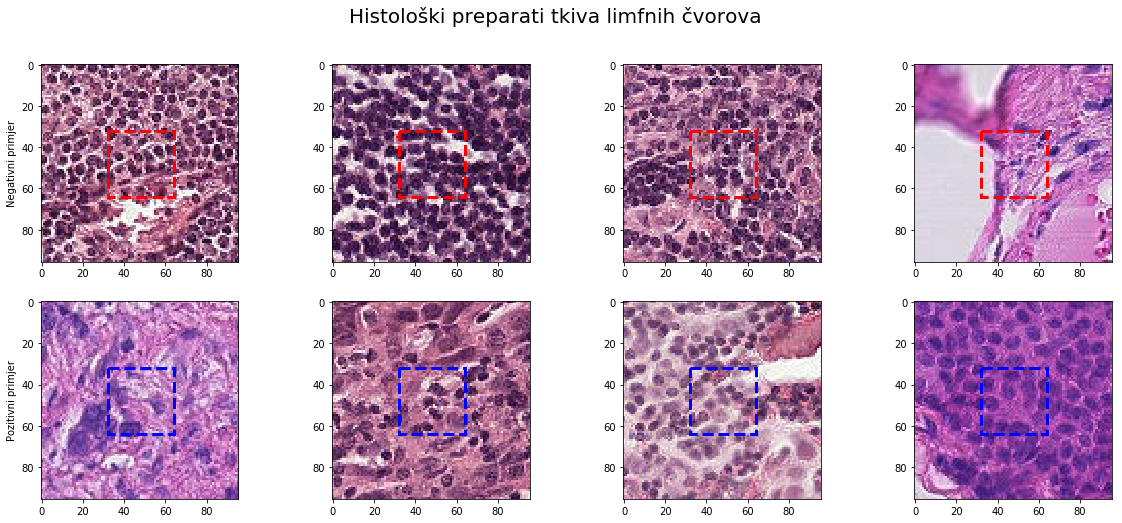

In [12]:
shuffled_data = shuffle(data) # Slučajni odabir podataka koje ćemo prikazati

fig, ax = plt.subplots(2,4, figsize=(20,8))

# Negativni primjeri
for i, id_slike in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:4]):
    path = os.path.join(train_path, id_slike)
    ax[0,i].imshow(readImage(path + '.tif'))

    box = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='red',facecolor='none',linestyle='--')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negativni primjer')

# Pozitivni primjeri
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:4]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))

    box = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='blue',facecolor='none',linestyle='--')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Pozitivni primjer')

fig.suptitle('Histološki preparati tkiva limfnih čvorova ',fontsize=20)

Golom je oku teško na temelju ovih fotografija detektirati tumorsko tkivo, ali mi nastojimo dobiti model koji to može uspješno napraviti.

## Statistička analiza primjera

Želimo vidjeti koja je srednja vrijednost i standardna devijacija za svaki kanal boje. Za pojedini kanal srednju vrijednost dobivamo tako da za svaku fotografiju pojedinačno izračunamo srednju vrijednost te potom sumu tih vrijednosti podijelimo brojem fotografija (primjera) - dobivamo $m$. Standardnu derivaciju za svaki ćemo pojedini kanal izračunati pomoću formule:
$$s = \sqrt{\sum_{i=1}^n \dfrac{x_i^2}{n} - m^2}$$
gdje je n ukupan broj fotografija (primjera).

In [13]:
def readImage2(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img / 255

In [14]:
taman_pixel = 10 / 255
svijetli_pixel = 245 / 255
pretamne_slike = []
presvijetle_slike = []
pozitivni_primjeri = []
negativni_primjeri = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
ukupno = 0

for i, id_slike in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, id_slike)
    rgb_slika = readImage2(path + '.tif').reshape(-1,3)
    # Pretamne i presvijetle slike ne želimo pa ih zabilježimo te nastavljamo
    if(rgb_slika.max() < taman_pixel):
        pretamne_slike.append(id_slike)
        continue

    if(rgb_slika.min() > svijetli_pixel):
        presvijetle_slike.append(id_slike)
        continue
    
    x_tot += rgb_slika.mean(axis=0)
    x2_tot += (rgb_slika**2).mean(axis=0)
    ukupno += 1

In [15]:
channel_avr = x_tot/ukupno
channel_std = np.sqrt(x2_tot/ukupno - channel_avr**2)
channel_avr, channel_std

(array([0.70244707, 0.54624322, 0.69645334]),
 array([0.23889325, 0.28209431, 0.21625058]))

In [16]:
channel_avr = np.around(channel_avr, decimals=3)
channel_std = np.around(channel_std, decimals=3)

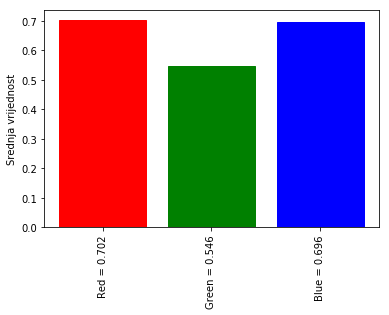

In [17]:
barlist = plt.bar([0, 1, 2], [channel_avr[0], channel_avr[1], channel_avr[2]]) # Crtamo bar graf frekvencija pojedinih vrijednosti ciljne varijable
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[2].set_color('b')
plt.xticks([0, 1, 2],["Red = {}".format(channel_avr[0]), "Green = {}".format(channel_avr[1]), "Blue = {}".format(channel_avr[2])], rotation=90)
plt.ylabel("Srednja vrijednost")
plt.show()

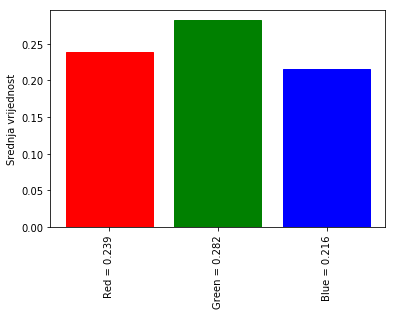

In [18]:
barlist = plt.bar([0, 1, 2], [channel_std[0], channel_std[1], channel_std[2]]) # Crtamo bar graf frekvencija pojedinih vrijednosti ciljne varijable
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[2].set_color('b')
plt.xticks([0, 1, 2],["Red = {}".format(channel_std[0]), "Green = {}".format(channel_std[1]), "Blue = {}".format(channel_std[2])], rotation=90)
plt.ylabel("Srednja vrijednost")
plt.show()

### Odbacivanje outliera

Tijekom računanja srednje vrijednosti i standardne devijacije u *pretamne_slike* i *presvijetle_slike* spremali smo primjere koji su bili pretamni ili presvijetli. Sada ih prikazujemo kako bismo vidjeli kako izgledaju:

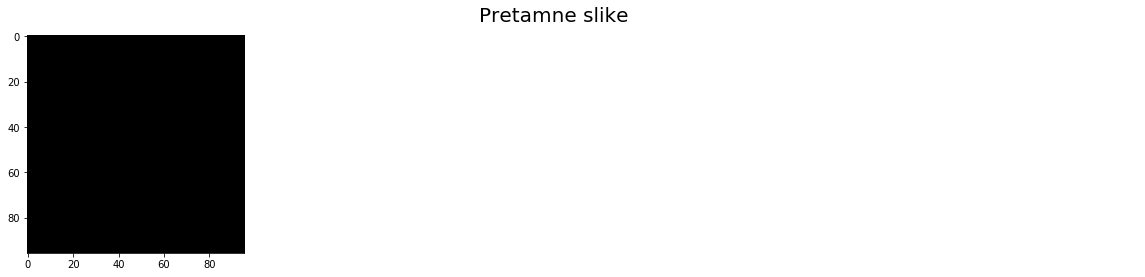

In [19]:
# Tamni primjeri
br_t = min(4, len(pretamne_slike))
fig, ax = plt.subplots(1,4,figsize=(20,4))
fig.suptitle('Pretamne slike',fontsize=20)

for i, id_slike in enumerate(pretamne_slike[:br_t]):
    labl = shuffled_data[shuffled_data['id'] == id_slike]['label']
    path = os.path.join(train_path, id_slike)
    ax[i].imshow(readImage2(path + '.tif'))

for i in range(br_t,4):
    ax[i].axis('off')

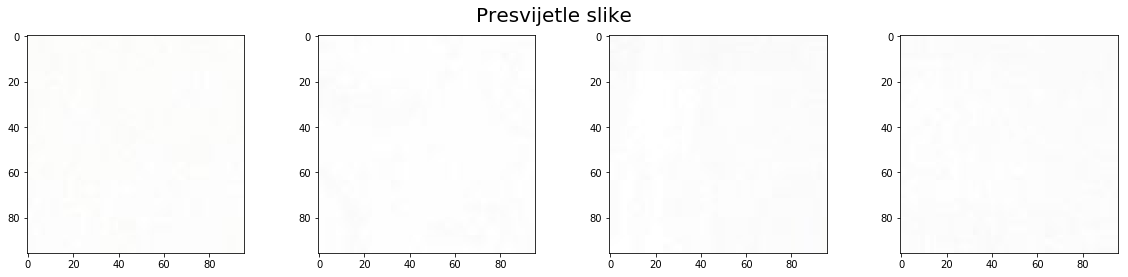

In [20]:
# Svijetli primjeri
br_s = min(4, len(presvijetle_slike))
fig, ax = plt.subplots(1,4,figsize=(20,4))
fig.suptitle('Presvijetle slike',fontsize=20)

for i, id_slike in enumerate(presvijetle_slike[:br_s]):
    labl = shuffled_data[shuffled_data['id'] == id_slike]['label']
    path = os.path.join(train_path, id_slike)
    ax[i].imshow(readImage2(path + '.tif'))

for i in range(br_s,4):
    ax[i].axis('off')

In [21]:
print("Ukupno takvih primjera je:", len(pretamne_slike)+len(presvijetle_slike))

Ukupno takvih primjera je: 7


Broj je takvih primjera 7, što je zanemarivo s obzirom na sveukupan broj train primjera pa se ne očekuje da će utjecati na prediktivnu moć modela.